# Emperor Penguin - 2090 difference from 2000
- Plot EP colony differences over time on CESM grid
- 2000, 2090, and difference (2090 - 2000)
- Needs to load files of EP colony distance and population
- Notebook by Alice DuVivier (NCAR)
- July 2025

In [1]:
import utils
import pandas as pd
import xarray as xr
import numpy as np
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import geopandas as gpd

## Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

## Read in SIZ data

In [6]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/environment/'

In [7]:
# load SIZ
file_in = 'CESM2-LE-SIZ.nc'
ds_siz = xr.open_dataset(path_in+file_in, decode_times=True)

In [8]:
data_siz = ds_siz.SIZ_SEP

### Calculate means for 2000s and 2090s and make mask

In [9]:
#  make temporary array with only ones for masks
mask_ones = np.ones([len(ds_siz.TLAT.nlat),len(ds_siz.TLAT.nlon)])
mask_ones = xr.DataArray(mask_ones,dims=('nlat','nlon'))
mask_ones['nlat'] = ds_siz.TLAT.nlat
mask_ones['nlon'] = ds_siz.TLAT.nlon

In [10]:
# use a threshold of 0.5 for SIZ zone. More than 50% of the time a point is in the SIZ if this is >= 0.5
thresh = 0.5

In [11]:
# choose decade
dec = 2000

# get start and end years based on above
yy_st = dec - 2
yy_ed = dec +3
yy = list(range(yy_st,yy_ed,1)) 

# subset data by year
temp = data_siz.isel(time=data_siz.time.isin([yy]))
# take mean over those years and all ensemble members
temp = temp.mean(dim=['time','member_id'])
# make mask of ones where it's in the SIZ and 0 everywhere else
siz_2000 = mask_ones.where(temp >= thresh)

In [12]:
# choose decade
dec = 2090

# get start and end years based on above
yy_st = dec - 2
yy_ed = dec +3
yy = list(range(yy_st,yy_ed,1)) 

# subset data by year
temp = data_siz.isel(time=data_siz.time.isin([yy]))
# take mean over those years and all ensemble members
temp = temp.mean(dim=['time','member_id'])
# make mask of ones where it's in the SIZ and 0 everywhere else
siz_2090 = mask_ones.where(temp >= thresh)

## Read in penguin data

### Ocean Accessibility by all colonies

In [13]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/penguin/'

In [14]:
# Read in AP data 
file_in = 'CESM_grid_Emperor_individual_access_future.nc'
ds_ep= xr.open_mfdataset(dir_in+file_in,decode_times=False)

In [15]:
# get data of interest
total_penguins = ds_ep.total_penguins

In [16]:
# choose decade
dec = 2000

# get start and end years based on above
yy_st = dec - 2
yy_ed = dec +3
yy = list(range(yy_st,yy_ed,1)) 

# subset data by year
temp = total_penguins.isel(time=total_penguins.time.isin([yy]))

# take mean over those years
data_mean_2000 = temp.mean(dim='time')

In [17]:
# choose decade
dec = 2090

# get start and end years based on above
yy_st = dec - 2
yy_ed = dec +3
yy = list(range(yy_st,yy_ed,1)) 

# subset data by year
temp = total_penguins.isel(time=total_penguins.time.isin([yy]))

# take mean over those years
data_mean_2090 = temp.mean(dim='time')

In [18]:
# calculate absolute and percent differences from 2000s
diff_abs = data_mean_2090 - data_mean_2000

# calculate percent difference
#diff_pct = 100.0* (diff_abs/data_mean_2000)
top = data_mean_2090 - data_mean_2000
bot = (data_mean_2090 + data_mean_2000)/2.0
diff_pct = 100.0 * abs(top/bot)

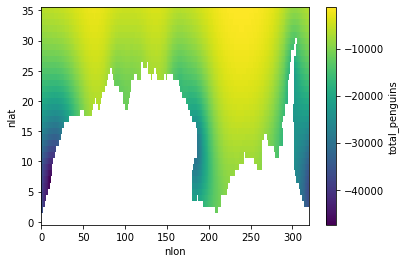

In [19]:
diff_abs.plot()

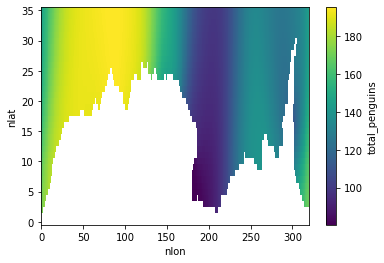

In [20]:
diff_pct.plot()

In [21]:
# mask the percent differences by where the difference is >10% (for stippling)
diff_pct_10 = mask_ones.where(abs(diff_pct) <= 10.0)

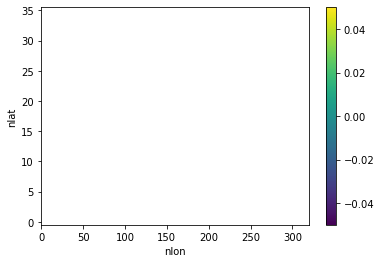

In [22]:
diff_pct_10.plot()

In [23]:
# mask the percent differences by the absolute difference is <1000 individuals
diff_abs_1000 = mask_ones.where(abs(diff_abs) <= 1000.0)

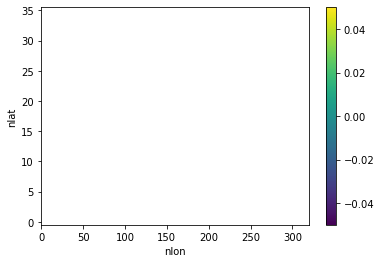

In [24]:
diff_abs_1000.plot()

## Invdividual Colony data

### Read in invdividual Colony location data

In [25]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/penguin/'

In [26]:
# load Emperor Penguin distances
file_in = 'CESM_grid_Emperor_colony_present_day.nc'
ds_ep = xr.open_dataset(path_in+file_in, decode_times=True)

In [27]:
ds_ep = ds_ep.rename({'index':'colonies'})

In [28]:
# get colony population info for plotting
data_col_lat = ds_ep.colony_lat
data_col_lon = ds_ep.colony_lon

### Read in individual Emperor colony population projections

In [29]:
# these population projections are for years 1900-2100
years = np.arange(1900,2101,1)
tlen = len(years)
print(tlen)

201


In [30]:
# load future Emperor Penguin population projections
file_in = 'Emperor_colony_future_projections_median_CMR.csv'
data = pd.read_csv(path_in + file_in)

In [31]:
data

,SNOW,JASN,DOLL,SMTH,GOUL,LUIT,HALY,DAWS,STCB,DRES,...,BEAR,BSON,NOVI,PFRO,BRYA,SMYL,VERD,ROTS,DION,DARL
0,3787.200,5561.6,9887.4,3424.70,4438.100,5251.900,12448.000,5385.500,6916.2000,7923.7000,...,1508.700,1497.000,1557.900,407.270,1180.700,1668.000,479.910,1530.700,447.630,408.000
1,3473.200,9186.2,9753.3,3467.50,4200.100,6500.900,12984.000,5773.400,7588.0000,7817.9000,...,1379.900,1451.500,1419.400,666.520,1161.300,1543.500,773.160,918.070,461.680,354.010
2,2895.900,10699.0,9572.0,3472.20,3887.200,6823.000,12589.000,5020.600,6852.7000,6297.7000,...,1047.100,1168.400,1032.800,691.330,939.260,1075.800,759.470,691.710,306.550,260.050
3,2452.300,11843.0,9397.9,3515.80,3608.600,7181.900,12239.000,4634.700,6432.3000,5648.4000,...,914.990,989.050,912.080,725.670,869.880,977.200,785.000,617.270,261.330,212.110
4,2126.100,12699.0,9300.9,3506.10,3460.300,7370.400,12045.000,4505.000,6427.2000,5401.2000,...,828.240,939.070,857.410,743.780,864.150,958.630,791.470,617.490,243.000,210.320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,36.406,2112.8,5476.0,1177.80,128.570,34.413,27.461,28.782,22.5750,11.8540,...,47.374,46.015,41.024,38.824,38.502,40.874,36.415,34.453,20.301,18.949
197,35.144,2065.3,5369.4,973.65,92.625,30.361,22.423,23.605,17.8470,9.2708,...,42.972,41.904,37.345,34.650,33.760,36.175,32.570,30.722,18.692,15.433
198,36.473,1809.2,5089.8,904.18,71.048,23.696,19.254,19.939,14.1610,7.3993,...,45.310,43.717,38.995,36.778,36.068,38.808,34.855,33.879,21.752,19.057
199,32.297,1753.5,4657.8,797.08,44.398,20.674,15.084,15.647,11.4960,5.6889,...,41.729,40.317,36.196,33.632,33.366,35.553,32.313,31.683,19.353,15.033


In [32]:
# convert future data to xarray
populations = xr.DataArray(data,dims=('year','colonies'))

In [33]:
# assign metadata
populations['year'] = years
populations['colonies'] = ds_ep.colonies

### Calculate population means for 2000s and 2090s to get health status

In [34]:
# choose decade
dec = 2000

# get start and end years based on above
yy_st = dec - 2
yy_ed = dec +3
yy = list(range(yy_st,yy_ed,1)) 

# subset data by year
temp = populations.isel(year=populations.year.isin([yy]))

# take mean over those years
pop_mean_2000 = temp.mean(dim='year')

In [35]:
# choose decade
dec = 2090

# get start and end years based on above
yy_st = dec - 2
yy_ed = dec +3
yy = list(range(yy_st,yy_ed,1)) 

# subset data by year
temp = populations.isel(year=populations.year.isin([yy]))

# take mean over those years
pop_mean_2090 = temp.mean(dim='year')

In [36]:
# calculate percent difference from 2000s to get colony health
pct_diff_pop = 100.0* ((pop_mean_2090 - pop_mean_2000)/pop_mean_2000)

## Load regional mask data and shapefiles

In [37]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [38]:
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v8_10102024.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

# keep just masks of interest (MPA planning areas, polynya regions, coastal)
ccamlr_in = ['mpa_plan_1','mpa_plan_2', 'mpa_plan_3', 'mpa_plan_4', 'mpa_plan_5', 'mpa_plan_6', 'mpa_plan_7','mpa_plan_8','mpa_plan_9','mpa_plan_1_mod','mpa_plan_3_mod','mpa_plan_4_mod','mpa_plan_3_4','mpa_plan_7_mod']
ccamlr_masks = ds_ccamlr[ccamlr_in]

# now load in the different masks as a new coordinate
ccamlr_masks = xr.concat([ds_ccamlr.mpa_plan_1, ds_ccamlr.mpa_plan_2, ds_ccamlr.mpa_plan_3,
                          ds_ccamlr.mpa_plan_4, ds_ccamlr.mpa_plan_5, ds_ccamlr.mpa_plan_6,
                          ds_ccamlr.mpa_plan_7, ds_ccamlr.mpa_plan_8, ds_ccamlr.mpa_plan_9,
                          ds_ccamlr.mpa_plan_1_mod, ds_ccamlr.mpa_plan_3_mod, ds_ccamlr.mpa_plan_4_mod, 
                          ds_ccamlr.mpa_plan_3_4, ds_ccamlr.mpa_plan_7_mod],
                         dim='region')
ccamlr_masks['region']=ccamlr_in


In [39]:
# Read in Antarctic Geography Shapefiles
file_in = 'USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp'

shdf_ant = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_ant = shdf_ant.to_crs(ccrs.SouthPolarStereo())

## Plot figures

In [40]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [41]:
# get colony distance info for plotting
lons = ds_grid.TLONG
lats = ds_grid.TLAT

In [42]:
# make arrays for the Amundsen/Peninsula region
lats_bound = np.arange(-73, -50, 1)
#lats_bound
lons_bound = np.linspace(275, 275, lats_bound.shape[0])
#lons_bound

In [43]:
# mask to omit land points
data_mean_2090 = data_mean_2090.where(ds_grid.REGION_MASK == 1)
diff_abs = diff_abs.where(ds_grid.REGION_MASK == 1)

In [44]:
# mask outside of average decadal SIZ zone
data_mean_2000 = data_mean_2000.where(siz_2000 >0)
data_mean_2090 = data_mean_2090.where(siz_2090 >0)
diff_abs = diff_abs.where(siz_2000 >0)
diff_pct = diff_pct.where(siz_2000 >0)
diff_pct_10 = diff_pct_10.where(siz_2000 >0)

In [45]:
# divide the data by 1000 to get better plotting
data_mean_2000 = data_mean_2000/1000.0
data_mean_2090 = data_mean_2090/1000.0
diff_abs = diff_abs/1000.0

### Set plotting ranges, etc.

In [46]:
print('maximum value for total population')
print(data_mean_2090.max(dim=['nlat','nlon']).values)

maximum value for total population
20.10608419962694


In [47]:
# set some plotting info
cmap_in = cmocean.cm.dense
vmin_in = 0.0
vmax_in = 50.0
levels_in_siz = np.arange(0,3,1)
levels_in_ctr = np.arange(0,3,1)

In [48]:
print('maximum and minimum absolute differences in total population 2090 - 2000')
print(diff_abs.max(dim=['nlat','nlon']).values)
print(diff_abs.min(dim=['nlat','nlon']).values)

maximum and minimum absolute differences in total population 2090 - 2000
-2.032972331520497
-47.458941107748025


In [49]:
# set some plotting info
cmap_diff = cmocean.cm.balance
vmin_diff = -40.0
vmax_diff = 40.0
vmin_pct_diff = -250.0
vmax_pct_diff = 250.0

In [70]:
# set circle colors for colonies
# loop through each colony population and set it based on 4 options (from Stef's previous work)
# 1 --> "healthy", colony population decrease < 30%
# 2 --> "vulnerable", colony_population decrease >= 30% and < 50%
# 3 --> "endangered", colony_population decrease >= 50% and < 90%
# 4 --> "quasi-extinct", colony population decrease >= 90%

clen = len(populations.colonies)
color_list = []

for col in np.arange(0,clen,1):
    value = pct_diff_pop.isel(colonies=col)
    if (value > -30.0):
        color = 'forestgreen'
        #color = 'darkviolet'
    elif ((value > -50.0) and (value <= -30.0)):
        color = 'greenyellow'
        #color = 'blue'
    elif ((value > -90.0) and (value <= -50.0)):
        color = 'gold'
    elif (value <= -90.0):
        #color = 'firebrick'
        color = 'chocolate'  #;'darkgoldenrod'
    # add to list
    color_list.append(color)

# Set some lats/lons, etc. for a legend
lons_leg = [0,0,0,0]
lats_leg = [-80.0,-83.0,-86.0,-89.0]
area_leg = [50,50,50,50]
#text_leg = ['Non-threatened','Vulnerable','Endangered','Quasi-extinct']
text_leg = ['NTH', 'VUL','END','QEX']

### Final Panel Plot

In [55]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_6/'
fout = 'Figure_6_Emperor_siz_polynya_2000_2090'

#labels
lab1 = 'j) EPP 2000s'
lab2 = 'k) EPP 2090s'
lab3 = 'l) EPP Difference'
sz = 20

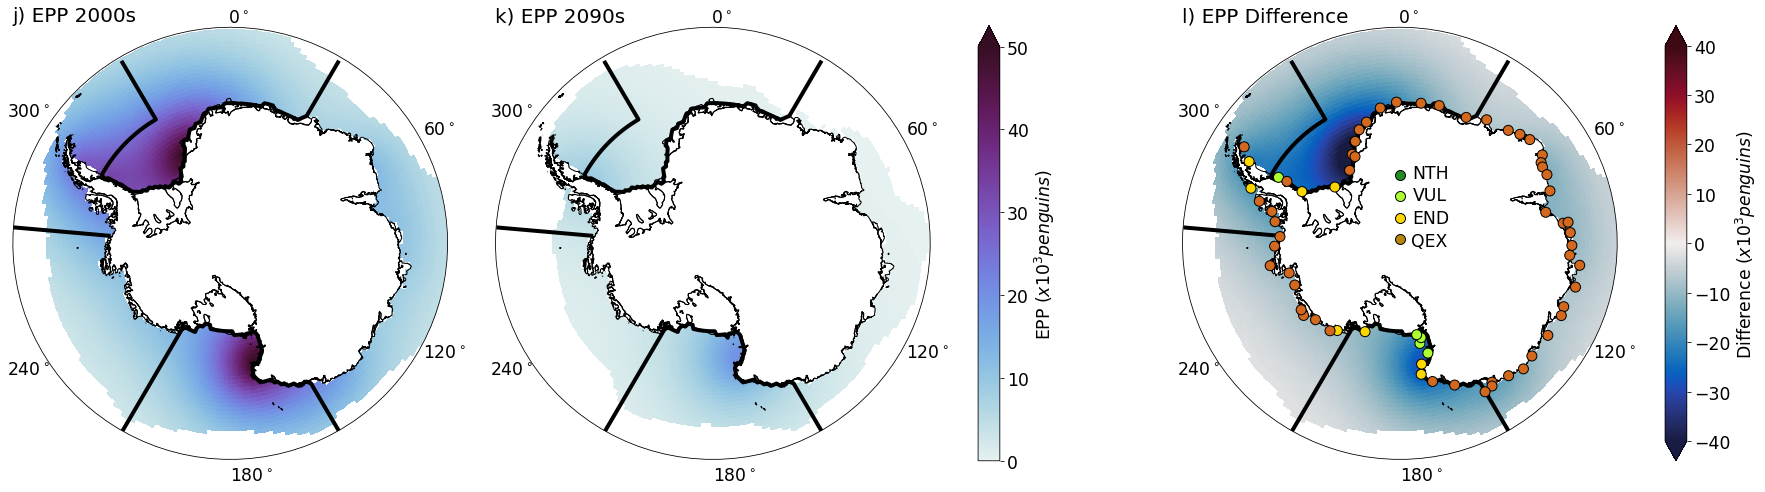

In [82]:
# Plot - percent difference (2090 - 2100)
# create figure
fig = plt.figure(figsize=(30,8))

# set plot spacing for the figure to include colorbars
gs = gridspec.GridSpec(nrows=1, ncols=6, width_ratios=(1, 1, 0.05, 0.2, 1, 0.05))

prj =ccrs.SouthPolarStereo()

# set all the different plot items
ax_map1 = plt.subplot(gs[0, 0], projection=prj)
ax_map2 = plt.subplot(gs[0, 1], projection=prj)
ax_map3 = plt.subplot(gs[0, 4], projection=prj)

ax_cb = plt.subplot(gs[0, 2])
ax_cb_diff = plt.subplot(gs[0, 5])

### Plot 1 - 2000 ###########################################################################
ax_map1.set_boundary(circle, transform=ax_map1.transAxes)
ax_map1.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax_map1.set_title(lab1,loc='left',fontsize=sz)
### Main Plot
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_mean_2000)
this=ax_map1.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
### Add Longitude Labels
# 0 Lon
ax_map1.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax_map1.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax_map1.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax_map1.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax_map1.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax_map1.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax_map1.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax_map1.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax_map1.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
### Add shapefile coastlines
ax_map1.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot 2 - 2090 ###########################################################################
ax_map2.set_boundary(circle, transform=ax_map2.transAxes)
ax_map2.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax_map2.set_title(lab2,loc='left',fontsize=sz)
### Main Plot
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_mean_2090)
this=ax_map2.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
### Add Longitude Labels
# 0 Lon
ax_map2.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax_map2.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax_map2.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax_map2.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax_map2.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax_map2.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax_map2.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax_map2.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax_map2.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
### Add shapefile coastlines
ax_map2.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

###################################### first color bar #################################
cbar1 = fig.colorbar(this, cax=ax_cb, extend='max')
cbar1.ax.tick_params(labelsize='xx-large')
cbar1.ax.set_ylabel(r'EPP ($x10^3 penguins$)',fontsize='xx-large')

### Plot 3 - Difference ###########################################################################
ax_map3.set_boundary(circle, transform=ax_map3.transAxes)
ax_map3.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax_map3.set_title(lab3,loc='left',fontsize=sz)
### Main Plot
lon, lat, field = utils.adjust_pop_grid(lons,lats,diff_abs)
this=ax_map3.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_diff,                      
                     vmax=vmax_diff, vmin=vmin_diff,
                     transform=ccrs.PlateCarree())
### Plot Colony Locations - sizes vary by colony size
this1=ax_map3.scatter(data_col_lon,data_col_lat,
                 color=color_list, edgecolor='black', s=100,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
### Add legend for colony size
# text for legend
#this2=ax_map3.text(-15.0,-76.5,
#              'Colony health',
#              color='black', fontsize='xx-large',
#              transform=ccrs.PlateCarree())
# first dot
n = 0
lon_plt = lons_leg[n]
lat_plt = lats_leg[n]
area_plt = area_leg[n]
text_plt = text_leg[n]
this3=ax_map3.scatter(lon_plt,lat_plt,
                 color='forestgreen', edgecolor='black', s=100,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this3t=ax_map3.text(lon_plt+10,lat_plt-0.25,
              text_plt,
              color='black', fontsize='xx-large',
              transform=ccrs.PlateCarree())
# second dot
n = 1
lon_plt = lons_leg[n]
lat_plt = lats_leg[n]
area_plt = area_leg[n]
text_plt = text_leg[n]
this4=ax_map3.scatter(lon_plt,lat_plt,
                 color='greenyellow', edgecolor='black', s=100,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this4t=ax_map3.text(lon_plt+15,lat_plt-0.25,
              text_plt,
              color='black', fontsize='xx-large',
              transform=ccrs.PlateCarree())
# third dot
n = 2
lon_plt = lons_leg[n]
lat_plt = lats_leg[n]
area_plt = area_leg[n]
text_plt = text_leg[n]
this5=ax_map3.scatter(lon_plt,lat_plt,
                 color='gold', edgecolor='black', s=100,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this5t=ax_map3.text(lon_plt+28,lat_plt-0.25,
              text_plt,
              color='black', fontsize='xx-large',
              transform=ccrs.PlateCarree())
# fourth dot
n = 3
lon_plt = lons_leg[n]
lat_plt = lats_leg[n]
area_plt = area_leg[n]
text_plt = text_leg[n]
this6=ax_map3.scatter(lon_plt,lat_plt,
                 color='darkgoldenrod', edgecolor='black', s=100,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this6t=ax_map3.text(lon_plt+90,lat_plt+0.5,
              text_plt,
              color='black', fontsize='xx-large',
              transform=ccrs.PlateCarree())
### Add Longitude Labels
# 0 Lon
ax_map3.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax_map3.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax_map3.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax_map3.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax_map3.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax_map3.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax_map3.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax_map3.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax_map3.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
### Add shapefile coastlines
ax_map3.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

###################################### second color bar #################################
cbar2 = fig.colorbar(this, cax=ax_cb_diff, extend='both')
cbar2.ax.tick_params(labelsize='xx-large')
cbar2.ax.set_ylabel(r'Difference ($x10^3 penguins$)',fontsize='xx-large')

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

### Individual Plots

In [ ]:
# Plot - absolute amounts in 2000
# create figure
fig = plt.figure(figsize=(10,10))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot info
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_mean_2000)
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='max',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_xlabel(r'#x1000 Emperor Penguins',fontsize='xx-large')

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

In [ ]:
# Plot - absolute amounts in 2090
# create figure
fig = plt.figure(figsize=(10,10))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot info
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_mean_2090)
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='max',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_xlabel(r'#x1000 Emperor Penguins',fontsize='xx-large')

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

In [ ]:
# Plot - absolute difference (2090 - 2100)
# create figure
fig = plt.figure(figsize=(10,10))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot info
lon, lat, field = utils.adjust_pop_grid(lons,lats,diff_abs)
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_diff,                      
                     vmax=vmax_diff, vmin=vmin_diff,
                     transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='both',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_xlabel(r'#x1000 Emperor Penguins',fontsize='xx-large')

### Plot Colony Locations - sizes vary by colony size
this1=ax.scatter(data_col_lon,data_col_lat,
                 color=color_list, edgecolor='black', s=100,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
### Add legend for colony size
# text for legend
this2=ax.text(-20.0,-81.0,
              'Colony health in 2090s',
              color='black', fontsize='x-large',
              transform=ccrs.PlateCarree())
# first dot
n = 0
lon_plt = lons_leg[n]
lat_plt = lats_leg[n]
area_plt = area_leg[n]
text_plt = text_leg[n]
this3=ax.scatter(lon_plt,lat_plt,
                 color='forestgreen', edgecolor='black', s=100,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this3t=ax.text(lon_plt+10,lat_plt-0.25,
              text_plt,
              color='black', fontsize='x-large',
              transform=ccrs.PlateCarree())
# second dot
n = 1
lon_plt = lons_leg[n]
lat_plt = lats_leg[n]
area_plt = area_leg[n]
text_plt = text_leg[n]
this4=ax.scatter(lon_plt,lat_plt,
                 color='greenyellow', edgecolor='black', s=100,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this4t=ax.text(lon_plt+15,lat_plt-0.25,
              text_plt,
              color='black', fontsize='x-large',
              transform=ccrs.PlateCarree())
# third dot
n = 2
lon_plt = lons_leg[n]
lat_plt = lats_leg[n]
area_plt = area_leg[n]
text_plt = text_leg[n]
this5=ax.scatter(lon_plt,lat_plt,
                 color='gold', edgecolor='black', s=100,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this5t=ax.text(lon_plt+28,lat_plt-0.25,
              text_plt,
              color='black', fontsize='x-large',
              transform=ccrs.PlateCarree())
# fourth dot
n = 3
lon_plt = lons_leg[n]
lat_plt = lats_leg[n]
area_plt = area_leg[n]
text_plt = text_leg[n]
this6=ax.scatter(lon_plt,lat_plt,
                 color='darkgoldenrod', edgecolor='black', s=100,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this6t=ax.text(lon_plt+70,lat_plt+0.18,
              text_plt,
              color='black', fontsize='x-large',
              transform=ccrs.PlateCarree())
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

In [ ]:
# Plot - absolute difference (2090 - 2100)
# create figure
fig = plt.figure(figsize=(10,10))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot info
lon, lat, field = utils.adjust_pop_grid(lons,lats,diff_pct)
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_diff,                      
                     vmax=vmax_pct_diff, vmin=vmin_pct_diff,
                     transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='both',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_xlabel('Difference (%)',fontsize='xx-large')

### Plot Colony Locations - sizes vary by colony size
this1=ax.scatter(data_col_lon,data_col_lat,
                 color=color_list, edgecolor='black', s=100,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
### Add legend for colony size
# text for legend
this2=ax.text(-20.0,-81.0,
              'Colony health in 2090s',
              color='black', fontsize='x-large',
              transform=ccrs.PlateCarree())
# first dot
n = 0
lon_plt = lons_leg[n]
lat_plt = lats_leg[n]
area_plt = area_leg[n]
text_plt = text_leg[n]
this3=ax.scatter(lon_plt,lat_plt,
                 color='forestgreen', edgecolor='black', s=100,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this3t=ax.text(lon_plt+10,lat_plt-0.25,
              text_plt,
              color='black', fontsize='x-large',
              transform=ccrs.PlateCarree())
# second dot
n = 1
lon_plt = lons_leg[n]
lat_plt = lats_leg[n]
area_plt = area_leg[n]
text_plt = text_leg[n]
this4=ax.scatter(lon_plt,lat_plt,
                 color='greenyellow', edgecolor='black', s=100,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this4t=ax.text(lon_plt+15,lat_plt-0.25,
              text_plt,
              color='black', fontsize='x-large',
              transform=ccrs.PlateCarree())
# third dot
n = 2
lon_plt = lons_leg[n]
lat_plt = lats_leg[n]
area_plt = area_leg[n]
text_plt = text_leg[n]
this5=ax.scatter(lon_plt,lat_plt,
                 color='gold', edgecolor='black', s=100,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this5t=ax.text(lon_plt+28,lat_plt-0.25,
              text_plt,
              color='black', fontsize='x-large',
              transform=ccrs.PlateCarree())
# fourth dot
n = 3
lon_plt = lons_leg[n]
lat_plt = lats_leg[n]
area_plt = area_leg[n]
text_plt = text_leg[n]
this6=ax.scatter(lon_plt,lat_plt,
                 color='darkgoldenrod', edgecolor='black', s=100,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this6t=ax.text(lon_plt+70,lat_plt+0.18,
              text_plt,
              color='black', fontsize='x-large',
              transform=ccrs.PlateCarree())
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)